In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 304)
(631390, 1)
validation
(74368, 304)
(74368, 1)
test
(85358, 304)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:27 - loss: 0.0214 - STD: 1.0437e-04 - MAE: 0.1294

 5/64 [=>............................] - ETA: 0s - loss: 0.0175 - STD: 5.2069e-05 - MAE: 0.1012  

 9/64 [===>..........................] - ETA: 0s - loss: 0.0150 - STD: 5.0744e-05 - MAE: 0.0926

13/64 [=====>........................] - ETA: 0s - loss: 0.0141 - STD: 6.2477e-05 - MAE: 0.0926

17/64 [======>.......................] - ETA: 0s - loss: 0.0132 - STD: 7.0150e-05 - MAE: 0.0889

21/64 [========>.....................] - ETA: 0s - loss: 0.0128 - STD: 7.8092e-05 - MAE: 0.0866

22/64 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 8.0604e-05 - MAE: 0.0861

26/64 [===========>..................] - ETA: 1s - loss: 0.0123 - STD: 9.3384e-05 - MAE: 0.0855

30/64 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 1.0524e-04 - MAE: 0.0848

34/64 [==============>...............] - ETA: 0s - loss: 0.0118 - STD: 1.1494e-04 - MAE: 0.0838

38/64 [================>.............] - ETA: 0s - loss: 0.0116 - STD: 1.2579e-04 - MAE: 0.0831

42/64 [==================>...........] - ETA: 0s - loss: 0.0115 - STD: 1.3873e-04 - MAE: 0.0829

46/64 [====================>.........] - ETA: 0s - loss: 0.0113 - STD: 1.5106e-04 - MAE: 0.0824

50/64 [======================>.......] - ETA: 0s - loss: 0.0112 - STD: 1.6316e-04 - MAE: 0.0820

54/64 [========================>.....] - ETA: 0s - loss: 0.0111 - STD: 1.7727e-04 - MAE: 0.0817

58/64 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 1.9243e-04 - MAE: 0.0815

62/64 [============================>.] - ETA: 0s - loss: 0.0110 - STD: 2.0749e-04 - MAE: 0.0812

64/64 [==============================] - 4s 34ms/step - loss: 0.0109 - STD: 2.1568e-04 - MAE: 0.0811 - val_loss: 0.0094 - val_STD: 3.7991e-04 - val_MAE: 0.0762


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0101 - STD: 4.9107e-04 - MAE: 0.0785

 5/64 [=>............................] - ETA: 0s - loss: 0.0100 - STD: 5.2507e-04 - MAE: 0.0785

 9/64 [===>..........................] - ETA: 0s - loss: 0.0100 - STD: 5.5730e-04 - MAE: 0.0784

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 5.9046e-04 - MAE: 0.0782

17/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 6.3041e-04 - MAE: 0.0782

21/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 6.7494e-04 - MAE: 0.0781

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 7.2330e-04 - MAE: 0.0780

29/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 7.7928e-04 - MAE: 0.0780

33/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 8.4124e-04 - MAE: 0.0778

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 9.1245e-04 - MAE: 0.0778

41/64 [==================>...........] - ETA: 0s - loss: 0.0098 - STD: 9.9639e-04 - MAE: 0.0778

45/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0778    

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0777

58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0776

62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0775

64/64 [==============================] - 1s 15ms/step - loss: 0.0098 - STD: 0.0019 - MAE: 0.0775 - val_loss: 0.0090 - val_STD: 0.0048 - val_MAE: 0.0749


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0094 - STD: 0.0061 - MAE: 0.0764

 5/64 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 0.0070 - MAE: 0.0763

 9/64 [===>..........................] - ETA: 0s - loss: 0.0093 - STD: 0.0079 - MAE: 0.0761

13/64 [=====>........................] - ETA: 0s - loss: 0.0092 - STD: 0.0091 - MAE: 0.0759

17/64 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 0.0105 - MAE: 0.0758

21/64 [========>.....................] - ETA: 0s - loss: 0.0091 - STD: 0.0121 - MAE: 0.0755

25/64 [==========>...................] - ETA: 0s - loss: 0.0090 - STD: 0.0140 - MAE: 0.0752

29/64 [============>.................] - ETA: 0s - loss: 0.0090 - STD: 0.0159 - MAE: 0.0749

33/64 [==============>...............] - ETA: 0s - loss: 0.0089 - STD: 0.0179 - MAE: 0.0746

37/64 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0198 - MAE: 0.0743

41/64 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0216 - MAE: 0.0739

45/64 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.0231 - MAE: 0.0737

49/64 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 0.0244 - MAE: 0.0734

54/64 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0258 - MAE: 0.0730

58/64 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0270 - MAE: 0.0727

62/64 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0280 - MAE: 0.0724

64/64 [==============================] - 1s 15ms/step - loss: 0.0084 - STD: 0.0285 - MAE: 0.0722 - val_loss: 0.0068 - val_STD: 0.0328 - val_MAE: 0.0629


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0076 - STD: 0.0447 - MAE: 0.0674

 5/64 [=>............................] - ETA: 0s - loss: 0.0074 - STD: 0.0450 - MAE: 0.0662

 9/64 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0454 - MAE: 0.0656

13/64 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0460 - MAE: 0.0652

17/64 [======>.......................] - ETA: 0s - loss: 0.0072 - STD: 0.0466 - MAE: 0.0649

21/64 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0473 - MAE: 0.0649

25/64 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0478 - MAE: 0.0648

29/64 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0485 - MAE: 0.0646

33/64 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0489 - MAE: 0.0644

37/64 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0493 - MAE: 0.0643

42/64 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0497 - MAE: 0.0641

46/64 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0500 - MAE: 0.0639

50/64 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0502 - MAE: 0.0638

54/64 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0505 - MAE: 0.0637

58/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0507 - MAE: 0.0636

62/64 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0509 - MAE: 0.0634

64/64 [==============================] - 1s 15ms/step - loss: 0.0070 - STD: 0.0510 - MAE: 0.0634 - val_loss: 0.0057 - val_STD: 0.0419 - val_MAE: 0.0585


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0560 - MAE: 0.0627

 5/64 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0551 - MAE: 0.0617

 9/64 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0550 - MAE: 0.0614

13/64 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0550 - MAE: 0.0615

17/64 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0552 - MAE: 0.0614

21/64 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0554 - MAE: 0.0612

25/64 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0610

29/64 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0557 - MAE: 0.0609

33/64 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0558 - MAE: 0.0609

37/64 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0559 - MAE: 0.0608

41/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0560 - MAE: 0.0606

45/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0606

49/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0562 - MAE: 0.0605

54/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0564 - MAE: 0.0604

58/64 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0604

62/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0603

64/64 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0567 - MAE: 0.0603 - val_loss: 0.0055 - val_STD: 0.0438 - val_MAE: 0.0558


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0565 - MAE: 0.0581

 5/64 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0593

 9/64 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0596

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0597

18/64 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0596

22/64 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0595

26/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0594

30/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0594

34/64 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0593

38/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0593

42/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0593

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0593

50/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0592

54/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0592

58/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0591

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0590

64/64 [==============================] - 1s 15ms/step - loss: 0.0062 - STD: 0.0594 - MAE: 0.0590 - val_loss: 0.0054 - val_STD: 0.0467 - val_MAE: 0.0565


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0576

 5/64 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0586

 9/64 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0585

13/64 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0609 - MAE: 0.0586

17/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0608 - MAE: 0.0585

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0609 - MAE: 0.0585

25/64 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0609 - MAE: 0.0586

29/64 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0608 - MAE: 0.0586

33/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0586

37/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0585

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0585

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0585

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0585

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0584

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0584

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0584

64/64 [==============================] - 1s 15ms/step - loss: 0.0061 - STD: 0.0610 - MAE: 0.0583 - val_loss: 0.0057 - val_STD: 0.0515 - val_MAE: 0.0606


Epoch 8/10000


 1/64 [..............................] - ETA: 0s - loss: 0.0064 - STD: 0.0630 - MAE: 0.0601

 5/64 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0583

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0581

17/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0583

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0583

25/64 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0583

29/64 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0581

33/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0582

37/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0582

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0582

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0582

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0582

53/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0616 - MAE: 0.0581

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0581

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0580

64/64 [==============================] - 1s 15ms/step - loss: 0.0060 - STD: 0.0618 - MAE: 0.0580 - val_loss: 0.0057 - val_STD: 0.0522 - val_MAE: 0.0602


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0646 - MAE: 0.0583

 5/64 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0632 - MAE: 0.0574

 9/64 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0579

13/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0576

17/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0578

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

25/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

29/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

33/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0579

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0579

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0579

45/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0578

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0578

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0578

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0578

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0578

64/64 [==============================] - 1s 15ms/step - loss: 0.0060 - STD: 0.0623 - MAE: 0.0578 - val_loss: 0.0056 - val_STD: 0.0522 - val_MAE: 0.0591


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0572

 5/64 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0580

 9/64 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0630 - MAE: 0.0586

13/64 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0625 - MAE: 0.0584

17/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0581

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0580

25/64 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0579

29/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0578

34/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0579

38/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0578

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0578

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0578

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0577

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0577

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0577

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0576

64/64 [==============================] - 1s 15ms/step - loss: 0.0060 - STD: 0.0624 - MAE: 0.0576 - val_loss: 0.0056 - val_STD: 0.0533 - val_MAE: 0.0599


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0648 - MAE: 0.0578

 5/64 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0638 - MAE: 0.0574

 9/64 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0637 - MAE: 0.0572

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0637 - MAE: 0.0572

17/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0571

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0573

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0573

29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0573

34/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0573

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0573

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0572

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0572

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0572

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0572

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0573

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0573

64/64 [==============================] - 1s 15ms/step - loss: 0.0059 - STD: 0.0633 - MAE: 0.0573 - val_loss: 0.0057 - val_STD: 0.0541 - val_MAE: 0.0612


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0646 - MAE: 0.0587

 5/64 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0572

 9/64 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0574

13/64 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

17/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0572

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

25/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0572

29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0572

33/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0573

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0573

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0574

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0574

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0575

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0579

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0624 - MAE: 0.0581

64/64 [==============================] - 1s 15ms/step - loss: 0.0061 - STD: 0.0621 - MAE: 0.0582 - val_loss: 0.0067 - val_STD: 0.0502 - val_MAE: 0.0685


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0602 - MAE: 0.0646

 6/64 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0554 - MAE: 0.0610

10/64 [===>..........................] - ETA: 0s - loss: 0.0064 - STD: 0.0554 - MAE: 0.0604

14/64 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0558 - MAE: 0.0600

18/64 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0564 - MAE: 0.0595

22/64 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0571 - MAE: 0.0591

26/64 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0589

30/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0586

34/64 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0585

38/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0594 - MAE: 0.0584

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0582

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0581

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0580

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0579

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0578

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0578

64/64 [==============================] - 1s 15ms/step - loss: 0.0060 - STD: 0.0610 - MAE: 0.0577 - val_loss: 0.0057 - val_STD: 0.0550 - val_MAE: 0.0610


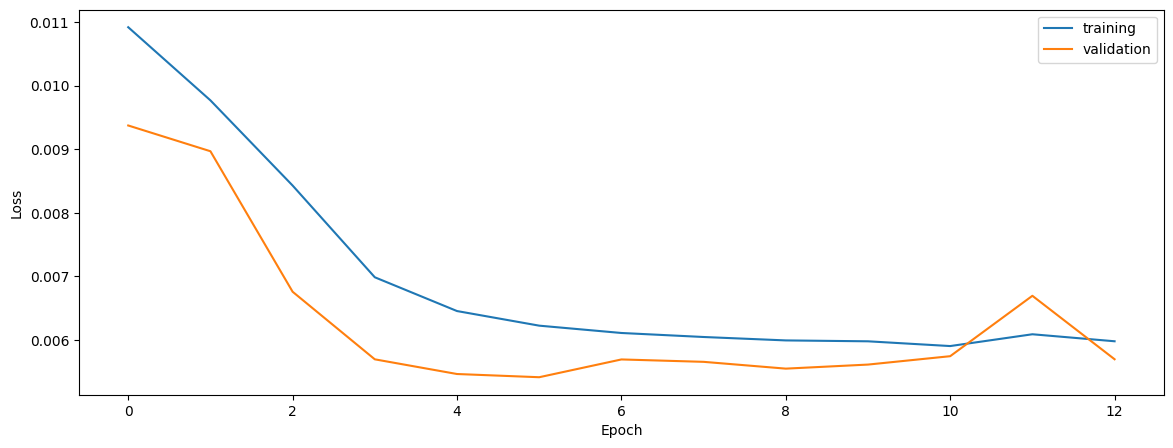

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6206129801069639
0.653931127991992
0.5819145126422535


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6206129801069639
0.653931127991992
0.5819145126422535


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6241716014797195
0.6576866999265055
0.6022683131648543


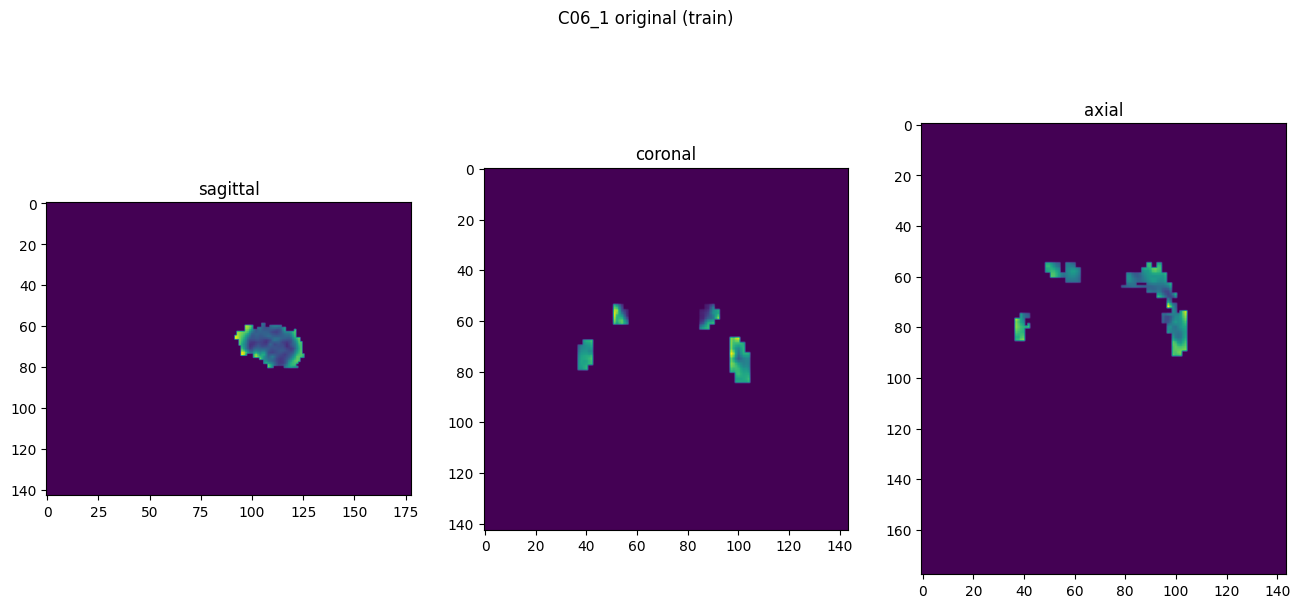

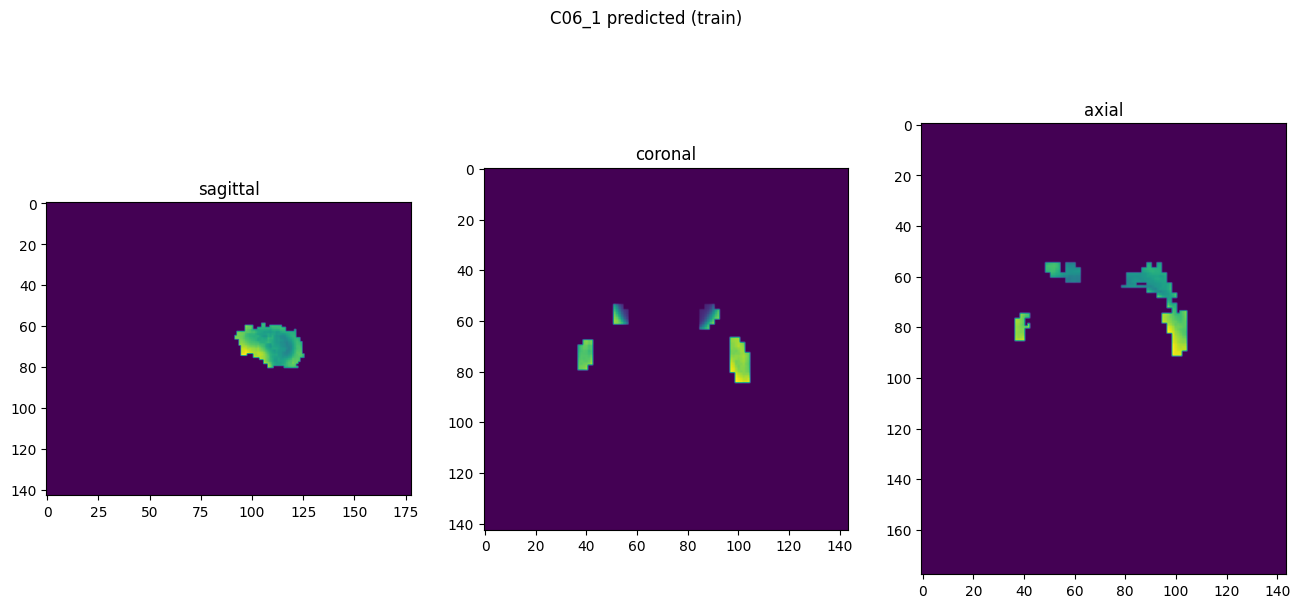

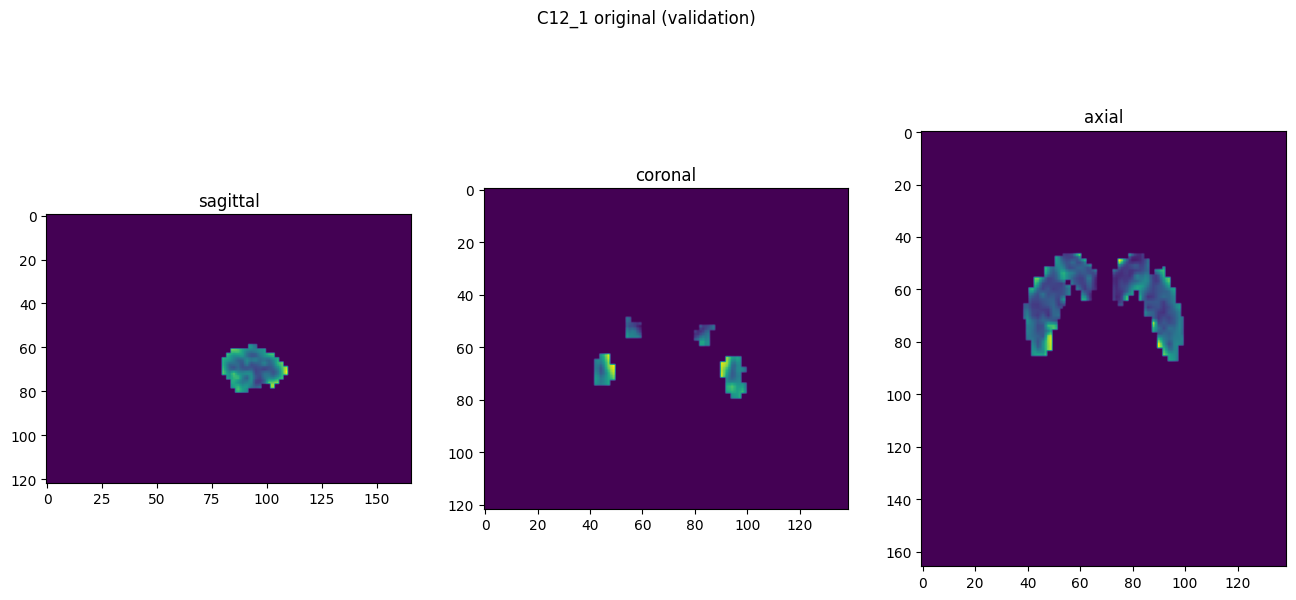

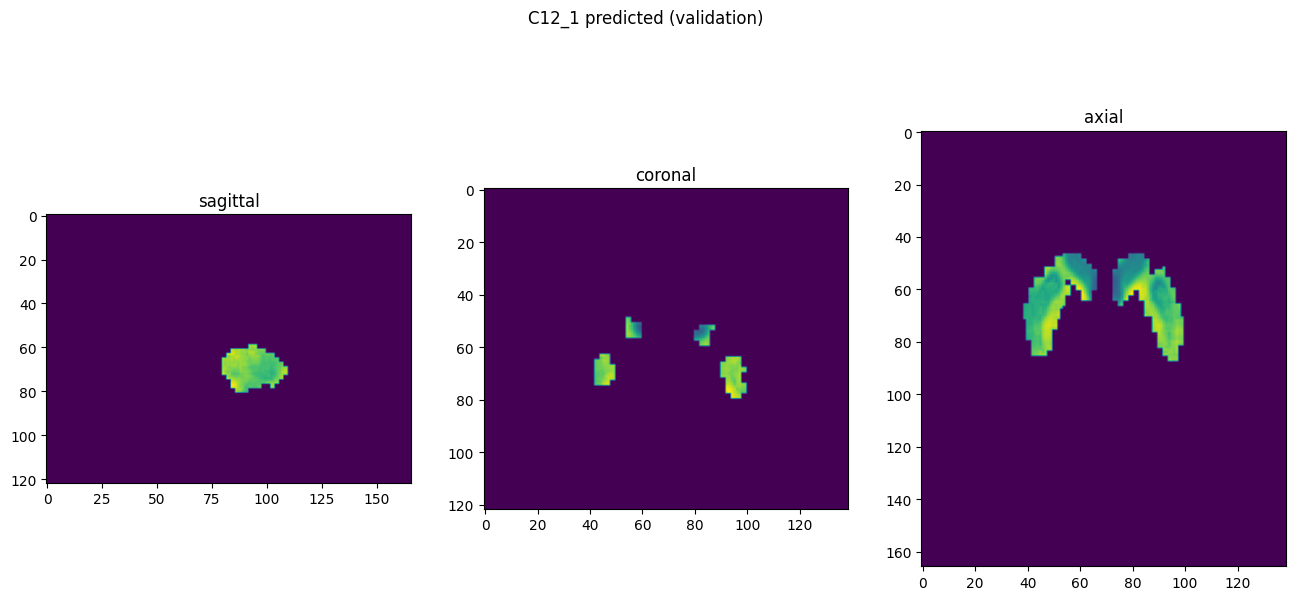

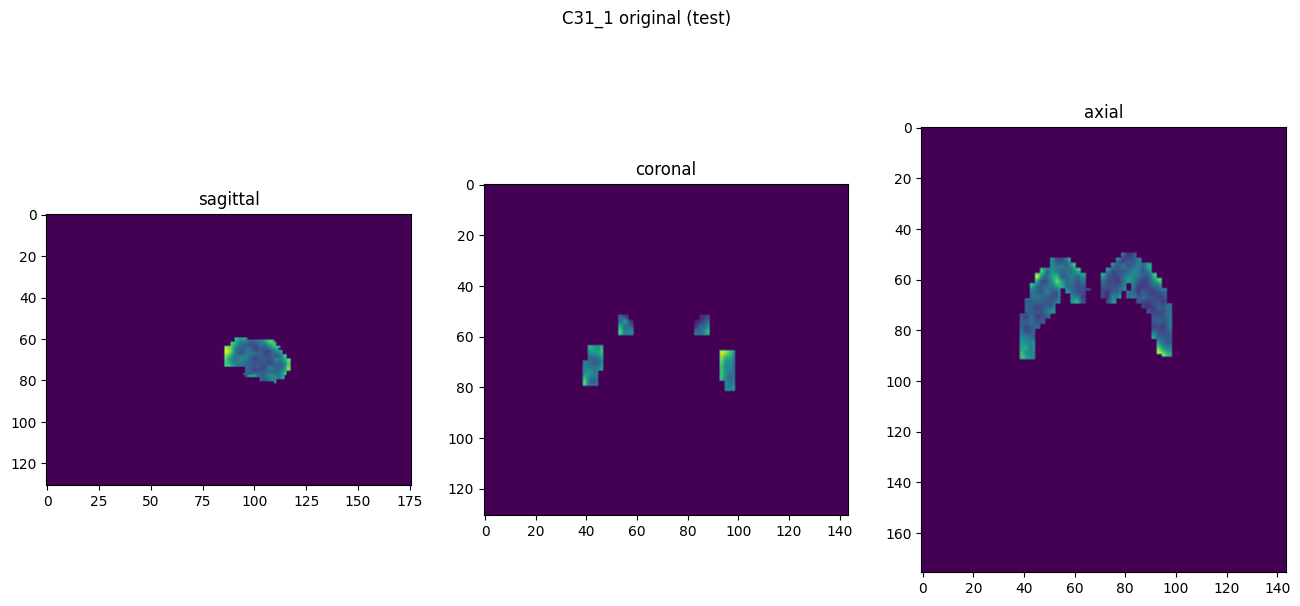

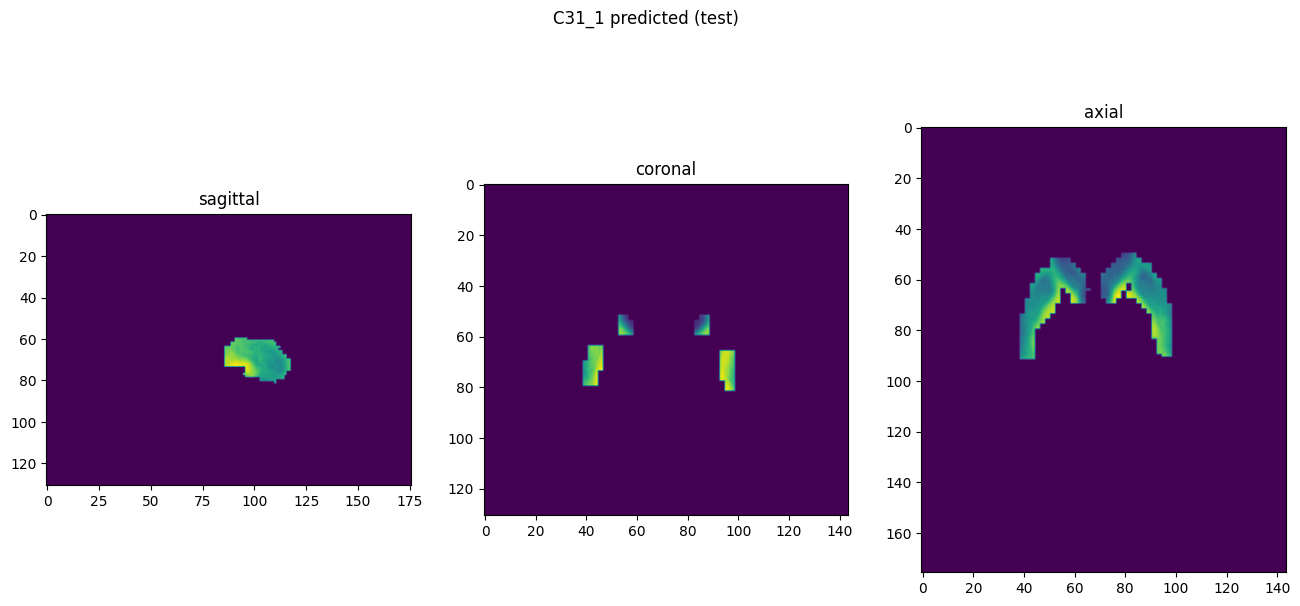

In [10]:
showResults(model, gen, threshold=None, background=False)